## **Sentiment Analysis, Model building and Prediction**

---



In this notebook we performed Sentiment Analysis of tweets for extracted shows for each user and then deep learning models are created. MLP models and Single layer models are created and results are evaluated. Recommendations are then made based on predicted sentiment scores for a user.

In [ ]:
# Install all libraries required to run the file
!pip install vaderSentiment
!pip install textblob
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install sklearn
!pip install keras

     |████████████████████████████████| 133kB 5.4MB/s 


In [ ]:
# Import libraries required to run the file
import re 
import pandas as pd 
pd.set_option("display.max_colwidth", 200)
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import csv
import plotly
import re

After pre-processing stage a final dataframe was created with user ids, extracted shownames and corresponding tweets which was then saved to a csv file "mytweetmodel". Read the csv file here and perform sentiment analysis.


In [ ]:
#Read the pre-processed data
df_tweets = pd.read_csv('mytweetmodel_.csv')
df_tweets.head()

,user_id,title,text,Genre,show_id,created
0,1026509053147664384,Love,i love Dave Chappelle.,Romance,81033200,2020-12-15 08:09:27
1,1031993857876086785,After,"After reading ""Santa's Stuck"" by Rhonda Gowler Greene, Mrs. Ortiz's fourth graders had to do their own drawing. The… https://t.co/O2LHXoP7W3",Romance,80244311,2020-12-18 18:31:19
2,1087549809551204352,Love,✨Love like there’s no tomorrow✨,Romance,81033200,2020-11-28 05:19:44
3,1121629253135556609,Still,🤔 I still count myself as new to the social work profession and have yet to read any of Brene Brown’s books..... wa… https://t.co/9D7FTz63ew,Horror,80999985,2020-10-04 06:36:22
4,1288184693201002500,Outlander,"@vicky_gilmour @Outlander_STARZ Yes, I think between 30-35 is a good “in our heads” age to stick with! Still young… https://t.co/kfpd4WDpFe",Romance,70285581,2020-10-14 21:30:57


In [ ]:
# Variable count
df_tweets.count()

user_id    6796
title      6796
text       6796
Genre      6796
show_id    6796
created    6796
dtype: int64

In [ ]:
#Dropping duplicates
df_user_tweet = df_tweets.drop_duplicates().reset_index(drop=True)
df_user_tweet.count()

user_id    5437
title      5437
text       5437
Genre      5437
show_id    5437
created    5437
dtype: int64

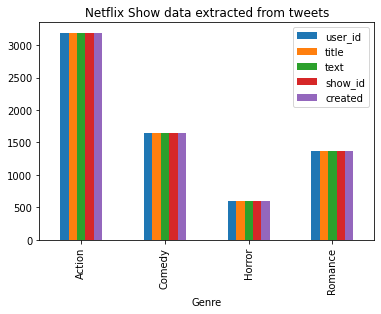

In [ ]:
# Data after preprocessing for each genre
import matplotlib

show_data = df_tweets.groupby('Genre').count().plot(kind='bar', title = 'Netflix Show data extracted from tweets')


For sentiment Analysis, first method we used was TextBlob. The sentiment function of textblob returns two properties: polarity and subjectivity. Polarity lies in the range [-1, 1] where 1 is postive statement and -1 is negative statement. Subjectivity lies in the range [0, 1] which gives information if its a public opinion or actual information.

In [ ]:
#Sentiment analysis for each user using TextBlob method

def sentiment_func(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None
    
df_user_tweet['pol_sub'] = df_user_tweet['text'].apply(sentiment_func)
df_user_tweet.head(10)

,user_id,title,text,Genre,show_id,created,pol_sub
0,1026509053147664384,Love,i love Dave Chappelle.,Romance,81033200,2020-12-15 08:09:27,"(0.5, 0.6)"
1,1031993857876086785,After,"After reading ""Santa's Stuck"" by Rhonda Gowler Greene, Mrs. Ortiz's fourth graders had to do their own drawing. The… https://t.co/O2LHXoP7W3",Romance,80244311,2020-12-18 18:31:19,"(0.3, 0.5)"
2,1087549809551204352,Love,✨Love like there’s no tomorrow✨,Romance,81033200,2020-11-28 05:19:44,"(0.0, 0.0)"
3,1121629253135556609,Still,🤔 I still count myself as new to the social work profession and have yet to read any of Brene Brown’s books..... wa… https://t.co/9D7FTz63ew,Horror,80999985,2020-10-04 06:36:22,"(0.08484848484848484, 0.2606060606060606)"
4,1288184693201002500,Outlander,"@vicky_gilmour @Outlander_STARZ Yes, I think between 30-35 is a good “in our heads” age to stick with! Still young… https://t.co/kfpd4WDpFe",Romance,70285581,2020-10-14 21:30:57,"(0.875, 0.6000000000000001)"
5,1306964901483618305,GoodMorningCall,"Goodmorning!! Today is the day!! 🥰 Let's start our day w/a smile,, and let's stream to our heart's content! 😊❤… https://t.co/e9brSqGu1t",Romance,80092878,2020-11-30 01:04:39,"(0.375, 0.1)"
6,1327467636964417538,Still,I still haven’t watched Frozen or Black panther 😭,Horror,80999985,2020-12-01 14:53:08,"(-0.16666666666666666, 0.43333333333333335)"
7,2310872064,SomethingintheRain,#SomethingToSay ironic how candice patton wants to take all the racist bullying so future black female actresses wo… https://t.co/h2oJX5dQPF,Romance,80990935,2020-11-29 22:14:59,"(0.046666666666666676, 0.34500000000000003)"
8,30398906,Thriller,iLOVE THE QUALITY 😍🖤 This Photo \n#THRILLER • #KINGOFPOP✨ #MICHAELJACKSON⚡️@michaeljackson #MJJ #MJ #MOONWALKER… https://t.co/iAKgh7m4Iu,Horror,81024557,2020-10-09 21:02:46,"(0.0, 0.0)"
9,3175485668,Remember,I remember one day a teacher from he asked us to write a motto to put on our desks/books to give us motivation. Wha… https://t.co/UawDv8h1dT,Action,80022605,2020-12-18 15:23:26,"(0.0, 0.0)"


In [ ]:
# Clean the tweets

def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    return df

In [ ]:
# Cleaning the data using clean_text function

data_clean = clean_text(df_user_tweet, 'text', 'text_clean')
data_clean.head()

,user_id,title,text,Genre,show_id,created,pol_sub,text_clean
0,1026509053147664384,Love,i love Dave Chappelle.,Romance,81033200,2020-12-15 08:09:27,"(0.5, 0.6)",i love dave chappelle
1,1031993857876086785,After,"After reading ""Santa's Stuck"" by Rhonda Gowler Greene, Mrs. Ortiz's fourth graders had to do their own drawing. The… https://t.co/O2LHXoP7W3",Romance,80244311,2020-12-18 18:31:19,"(0.3, 0.5)",after reading santas stuck by rhonda gowler greene mrs ortizs fourth graders had to do their own drawing the
2,1087549809551204352,Love,✨Love like there’s no tomorrow✨,Romance,81033200,2020-11-28 05:19:44,"(0.0, 0.0)",love like theres no tomorrow
3,1121629253135556609,Still,🤔 I still count myself as new to the social work profession and have yet to read any of Brene Brown’s books..... wa… https://t.co/9D7FTz63ew,Horror,80999985,2020-10-04 06:36:22,"(0.08484848484848484, 0.2606060606060606)",i still count myself as new to the social work profession and have yet to read any of brene browns books wa
4,1288184693201002500,Outlander,"@vicky_gilmour @Outlander_STARZ Yes, I think between 30-35 is a good “in our heads” age to stick with! Still young… https://t.co/kfpd4WDpFe",Romance,70285581,2020-10-14 21:30:57,"(0.875, 0.6000000000000001)",gilmour starz yes i think between is a good in our heads age to stick with still young


Sentiment Analysis using VADER method: this method analyses the text and assign a compound score as well as positive, negative and neutral scores. we classified the text with postive, negative and neutral scores based on a threshold of compound score of 0.05. If compound score > = 0.05 then postive score is assigned, if its <= -0.05 then negative score is assigned. Otherwise neutral score is assigned.

In [ ]:
#Sentiment Analysis: assign sentiment scores for each user based on the tweet using vader sentiment

analyzer = SentimentIntensityAnalyzer()

scores = []
# Declare variables for scores
compound_list = []
positive_list = []
negative_list = []
neutral_list = []

for i in range(data_clean['text_clean'].shape[0]):
    compound = analyzer.polarity_scores(data_clean['text_clean'][i])["compound"]
    pos = analyzer.polarity_scores(data_clean['text_clean'][i])["pos"]
    neu = analyzer.polarity_scores(data_clean['text_clean'][i])["neu"]
    neg = analyzer.polarity_scores(data_clean['text_clean'][i])["neg"]
    
    if compound >= 0.05:
        scores.append({"Sentiment_score" : pos})
        
    elif compound <= -0.05:
        scores.append({"Sentiment_score" : neg})
        
    else:
        scores.append({"Sentiment_score" : neu})

In [ ]:
#Sentiment data with tweets

sentiments_score = pd.DataFrame.from_dict(scores)
data_clean = data_clean.join(sentiments_score)
data_clean.head()



,user_id,title,text,Genre,show_id,created,pol_sub,text_clean,Sentiment_score
0,1026509053147664384,Love,i love Dave Chappelle.,Romance,81033200,2020-12-15 08:09:27,"(0.5, 0.6)",i love dave chappelle,0.583
1,1031993857876086785,After,"After reading ""Santa's Stuck"" by Rhonda Gowler Greene, Mrs. Ortiz's fourth graders had to do their own drawing. The… https://t.co/O2LHXoP7W3",Romance,80244311,2020-12-18 18:31:19,"(0.3, 0.5)",after reading santas stuck by rhonda gowler greene mrs ortizs fourth graders had to do their own drawing the,0.100
2,1087549809551204352,Love,✨Love like there’s no tomorrow✨,Romance,81033200,2020-11-28 05:19:44,"(0.0, 0.0)",love like theres no tomorrow,0.615
3,1121629253135556609,Still,🤔 I still count myself as new to the social work profession and have yet to read any of Brene Brown’s books..... wa… https://t.co/9D7FTz63ew,Horror,80999985,2020-10-04 06:36:22,"(0.08484848484848484, 0.2606060606060606)",i still count myself as new to the social work profession and have yet to read any of brene browns books wa,1.000
4,1288184693201002500,Outlander,"@vicky_gilmour @Outlander_STARZ Yes, I think between 30-35 is a good “in our heads” age to stick with! Still young… https://t.co/kfpd4WDpFe",Romance,70285581,2020-10-14 21:30:57,"(0.875, 0.6000000000000001)",gilmour starz yes i think between is a good in our heads age to stick with still young,0.259


File containing IMDB scores of all titles is read into a dataframe and titles for which IMDB rating is "Not found" is made Null and then imputed with mean of IMDB ratings. Ratings are then rounded off to 1 decimal point.

In [ ]:
# Read the IMDB file created in the preprocessing section

netflix_ratings = pd.read_csv('mynetflixcsv (1).csv')
netflix_ratings.rename({'IMDB_title': 'title'}, axis=1, inplace=True)
netflix_ratings.rename({'rating': 'IMDB_rating'}, axis=1, inplace=True)
netflix_ratings.head()

,title,IMDB_rating
0,Jandino: Whatever it Takes,5.2
1,Marc Maron: Too Real,7.2
2,Mo Gilligan: Momentum,6.3
3,Def Comedy Jam 25,6.6
4,Jeff Dunham: Beside Himself,6.8


In [ ]:
netflix_ratings.dtypes

title          object
IMDB_rating    object
dtype: object

In [ ]:
# Filter df rows which have no IMDB rating (columns value = Not)

netflix_ratings[netflix_ratings['IMDB_rating'] == 'Not']

,title,IMDB_rating
86,Dave Chappelle,Not
118,Tig,Not
160,Bill Hicks: One Night Stand,Not
173,Dave Chappelle: Equanimity & The Bird Revelation,Not
191,Jim Jefferies : BARE,Not
...,...,...
1432,Soul Robbers,Not
1444,Pari,Not
1502,Game Over (Hindi Version),Not
1503,Game Over (Tamil Version),Not


In [ ]:
# Replace the 'Not' value with NaN

netflix_ratings.replace(to_replace={'IMDB_rating': {'Not': np.nan}},
           inplace=True)

In [ ]:
netflix_ratings.head(90)

,title,IMDB_rating
0,Jandino: Whatever it Takes,5.2
1,Marc Maron: Too Real,7.2
2,Mo Gilligan: Momentum,6.3
3,Def Comedy Jam 25,6.6
4,Jeff Dunham: Beside Himself,6.8
...,...,...
85,Nate Bargatze: The Tennessee Kid,7.6
86,Dave Chappelle,NaN
87,Amy Schumer Growing,5.2
88,Jimmy Carr: Funny Business,7.2


In [ ]:
#Impute the NaN values with total mean of the IMDB ratings

netflix_ratings['IMDB_rating'] = pd.to_numeric(netflix_ratings['IMDB_rating'])
netflix_ratings['IMDB_rating'].fillna(netflix_ratings['IMDB_rating'].mean(), inplace=True)
netflix_ratings.head(90)

,title,IMDB_rating
0,Jandino: Whatever it Takes,5.20000
1,Marc Maron: Too Real,7.20000
2,Mo Gilligan: Momentum,6.30000
3,Def Comedy Jam 25,6.60000
4,Jeff Dunham: Beside Himself,6.80000
...,...,...
85,Nate Bargatze: The Tennessee Kid,7.60000
86,Dave Chappelle,6.40171
87,Amy Schumer Growing,5.20000
88,Jimmy Carr: Funny Business,7.20000


In [ ]:
#Round of the deimals of rating value

netflix_ratings['IMDB_rating'] = netflix_ratings['IMDB_rating'].round(decimals=1)
netflix_ratings.head(90)

,title,IMDB_rating
0,Jandino: Whatever it Takes,5.2
1,Marc Maron: Too Real,7.2
2,Mo Gilligan: Momentum,6.3
3,Def Comedy Jam 25,6.6
4,Jeff Dunham: Beside Himself,6.8
...,...,...
85,Nate Bargatze: The Tennessee Kid,7.6
86,Dave Chappelle,6.4
87,Amy Schumer Growing,5.2
88,Jimmy Carr: Funny Business,7.2


Dataframe with IMDB values and dataframe with sentiment scores are joined on title in order to merge IMDB ratings to the final dataframe

In [ ]:
# Join the IMDB values with the sentiment score dataframe

final_data_sentiment = data_clean[["title", "Sentiment_score"]]
final_data_ratings = netflix_ratings[["title", "IMDB_rating"]]
netflix_userrating_inner = pd.merge(data_clean, final_data_ratings, on='title', how='inner')
netflix_userrating_inner.head()

,user_id,title,text,Genre,show_id,created,pol_sub,text_clean,Sentiment_score,IMDB_rating
0,1026509053147664384,Love,i love Dave Chappelle.,Romance,81033200,2020-12-15 08:09:27,"(0.5, 0.6)",i love dave chappelle,0.583,6.1
1,1087549809551204352,Love,✨Love like there’s no tomorrow✨,Romance,81033200,2020-11-28 05:19:44,"(0.0, 0.0)",love like theres no tomorrow,0.615,6.1
2,2434220706,Love,I LOVE Dave Chappelle. The man is a global treasure. Miss me with the “he walked away from ___ amount of money” you… https://t.co/xtmQQfHiMD,Romance,81033200,2020-11-28 14:22:43,"(0.25, 0.3)",i love dave chappelle the man is a global treasure miss me with the he walked away from amount of money you,0.237,6.1
3,1245164638964080642,Love,"I love how @TXT_members cover 2nd Gen songs, it always feels closer to heart. No one does it like txt. Hug by TVXQ… https://t.co/P9GoXHCxp7",Romance,81033200,2020-12-18 13:05:40,"(0.25, 0.3)",i love how members cover nd gen songs it always feels closer to heart no one does it like txt hug by tvxq,0.409,6.1
4,1332494377718001666,Love,I love when people act too good to watch anime like grow up,Romance,81033200,2020-11-30 03:35:32,"(0.6, 0.6000000000000001)",i love when people act too good to watch anime like grow up,0.490,6.1


In [ ]:
# Filter only required columns
netflix_rating_sentiment = netflix_userrating_inner[['user_id', 'title', 'Genre', 'Sentiment_score', 'IMDB_rating']]
netflix_rating_sentiment.head()

,user_id,title,Genre,Sentiment_score,IMDB_rating
0,1026509053147664384,Love,Romance,0.583,6.1
1,1087549809551204352,Love,Romance,0.615,6.1
2,2434220706,Love,Romance,0.237,6.1
3,1245164638964080642,Love,Romance,0.409,6.1
4,1332494377718001666,Love,Romance,0.490,6.1


CSV file with all Netflix titles is read into a dataframe and then merged with final datafarme on title to include show ids.

In [ ]:
# Read the actual show title files inorder to retrieve the show ids

df_shows = pd.read_csv('Netflix_updated.csv')
df_show_id = df_shows[['show_id','title']]


In [ ]:
# Join the above file on title to create a dataframe with showid, userid, sentiment score, IMDB rating, Genre, title

df_final_showdata =  pd.merge(df_show_id, netflix_rating_sentiment, on='title', how='inner')
df_final_showdata.head()

,show_id,title,user_id,Genre,Sentiment_score,IMDB_rating
0,80049872,Chelsea,547940165,Comedy,1.000,6.4
1,80049872,Chelsea,19917894,Comedy,1.000,6.4
2,80049872,Chelsea,802353711573909504,Comedy,0.227,6.4
3,80049872,Chelsea,852973970026516480,Comedy,1.000,6.4
4,80049872,Chelsea,852973970026516480,Comedy,1.000,6.4


In [ ]:
# Copy the dataframe and drop duplicates if any
df_model_data = df_final_showdata
df_model_data = df_model_data.drop_duplicates().reset_index(drop=True)
df_model_data.head()

,show_id,title,user_id,Genre,Sentiment_score,IMDB_rating
0,80049872,Chelsea,547940165,Comedy,1.000,6.4
1,80049872,Chelsea,19917894,Comedy,1.000,6.4
2,80049872,Chelsea,802353711573909504,Comedy,0.227,6.4
3,80049872,Chelsea,852973970026516480,Comedy,1.000,6.4
4,80049872,Chelsea,852973970026516480,Comedy,0.259,6.4


Dataframe is sorted based on sentiment score and duplicate records are removed keeping only the highest sentiment score.

In [ ]:
# Removing duplicates for the model data
df_model_data = df_model_data.sort_values('Sentiment_score').drop_duplicates(subset=['show_id', 'title', 'user_id', 'Genre', 'IMDB_rating', ], keep='last').reset_index(drop=True)


In [ ]:
# Movie details for the model after cleaning the data and removing duplicates

df_model_d = df_model_data[['title', 'Sentiment_score', 'IMDB_rating']].drop_duplicates()
df_model_d = df_model_d.sort_values('Sentiment_score').drop_duplicates(subset=['title', 'IMDB_rating'], keep='last').reset_index(drop=True)
df_model_d.dropna()
df_model_d

,title,Sentiment_score,IMDB_rating
0,Tango,0.082,7.1
1,Incomplete,0.133,5.4
2,Sabrina,0.139,6.6
3,Rocky,0.159,8.1
4,Delirium,0.166,5.7
...,...,...,...
76,Her,1.000,8.0
77,Three,1.000,7.4
78,Love,1.000,6.1
79,Boss,1.000,7.0


Average sentiment score for each show is calaculated along with its count and visualized.

In [ ]:
# Mean Sentiment score for the whole movie dataset

senti_mean = pd.DataFrame(df_model_data.groupby('title')['Sentiment_score'].mean())
senti_mean['Mean_count'] = pd.DataFrame(df_model_data.groupby('title')['Sentiment_score'].count())

senti_mean

,Sentiment_score,Mean_count
title,,
After,0.413829,170
Amar,0.167000,1
Apostle,0.198000,2
Arrow,0.210000,1
Backcountry,0.267000,1
...,...,...
Troy,0.149000,2
Velvet,0.232000,1
Veronica,0.295800,5


In [ ]:
# Import libraries required for model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Concatenate, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, Reshape, Concatenate
import tensorflow as tf
from tensorflow import keras


All categorical variables such as show id, user id and genre are transformed into numerical values using Labelencoder

In [ ]:
# Encode genre to numerical values
 
genre_enc = LabelEncoder()

df_model_data["genre_encoded"] = genre_enc.fit_transform(df_model_data["Genre"])
n_genre = df_model_data['genre_encoded'].nunique()

df_model_data[["genre_encoded", "Genre"]].head(11)


,genre_encoded,Genre
0,0,Action
1,0,Action
2,0,Action
3,0,Action
4,0,Action
5,0,Action
6,0,Action
7,0,Action
8,0,Action
9,0,Action


In [ ]:
#user encoding 
# creating instance of labelencoder

user_enc = LabelEncoder()

df_model_data['user'] = user_enc.fit_transform(df_model_data['user_id'].values)
n_users = df_model_data['user_id'].nunique()


In [ ]:
df_model_data

,show_id,title,user_id,Genre,Sentiment_score,IMDB_rating,genre_encoded,user
0,20255837,Don,2164164273,Action,0.042,6.4,0,587
1,20255837,Don,1282325107537477632,Action,0.053,6.4,0,1245
2,20255837,Don,3354694874,Action,0.057,6.4,0,709
3,70066433,Next,20462084,Action,0.057,6.9,0,41
4,80022605,Remember,1240841347344580608,Action,0.058,7.5,0,1147
...,...,...,...,...,...,...,...,...
1414,80022605,Remember,24446195,Action,1.000,7.5,0,57
1415,81033200,Love,328605589,Romance,1.000,6.1,3,331
1416,80227516,Chosen,911822348591915008,Action,1.000,7.4,0,863
1417,80022605,Remember,1201746874589417473,Action,1.000,7.5,0,1098


In [ ]:

# show and movie data encoding 
item_enc = LabelEncoder()
df_model_data['show'] = item_enc.fit_transform(df_model_data['show_id'].values)
n_movies = df_model_data['show'].nunique()


In [ ]:
df_data = df_model_data[['show', 'user', 'IMDB_rating', 'Sentiment_score', 'genre_encoded']]
df_data.head()

,show,user,IMDB_rating,Sentiment_score,genre_encoded
0,2,587,6.4,0.042,0
1,2,1245,6.4,0.053,0
2,2,709,6.4,0.057,0
3,12,41,6.9,0.057,0
4,33,1147,7.5,0.058,0


The below graph shows the data distribution of shows ,
sentiment score and corresponding IMDB rating. We can see that most of the shows sentiment score varies between 0.1 to 0.5 and it's IMDB rating is really high for shows. Surprisingly we can see that there are higher sentiment for few movies but the IMDB ratings are varying from low to high based on the data analysis. Here we are checking how user sentiments are varying with the rating data for no of shows. We can see that there are many secenarios.
















In [ ]:
#Parallel Coordinates plot 

df_data_1 = df_data[['show', 'Sentiment_score', 'IMDB_rating']].drop_duplicates()

import plotly.express as px

fig = px.parallel_coordinates(df_data_1, color=df_data_1['show'], labels={"show_id": "show",
                "Sentiment_score": "Sentiment_score", "IMDB_rating": "IMDB_rating"},
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)
fig.show()

In [ ]:
#sorting the dataframe based on sentiment score 

df_data = df_data.sort_values('Sentiment_score', ascending=True) 
df_data.show.nunique()

81

The code below shows toal number of unique users and shows, minimum and maximum sentiment scores in the dataset and minimum and maximum IMDB ratings.

In [ ]:
# min and max ratings will be used to normalize the ratings later
min_rating = min(df_data["IMDB_rating"])
max_rating = max(df_data["IMDB_rating"])

min_senti_score = min(df_data["Sentiment_score"])
max_senti_score = max(df_data["Sentiment_score"])

n_users = len(df_data.user.unique())
n_shows = len(df_data.show.unique())
n_genre = len(df_data.genre_encoded.unique())
print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}, Min sentiment score: {}, Max sentiment score: {}, Number of unique Genres: {}".format(
        n_users, n_shows, min_rating, max_rating, min_senti_score, max_senti_score, n_genre
    )
)

Number of users: 1414, Number of Movies: 81, Min rating: 3.3, Max rating: 8.7, Min sentiment score: 0.042, Max sentiment score: 1.0, Number of unique Genres: 4


# Model Building
Data preparation and model creation

Data is split into test and train sets. 25% of data is taken for testing and 75% training. Target variable is Sentiment_score and dependent variables are user ids and show ids.


In [ ]:
# Create testing and training datasets.

df_data.sample(frac=1, random_state=42)

#Normalize the IMDB ratings to the range 0 to 1
df_data['rating'] = df_data[['IMDB_rating']].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

X = df_data[['show', 'user', 'rating', 'genre_encoded']].values
y = df_data['Sentiment_score'].values

#Split to test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1064, 4), (355, 4), (1064,), (355,))

In [ ]:
# Create numpy array of dependent variables (show ids and user ids)
n_factors = 10

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]


In [ ]:
#Describe the training dataset
df_describe = pd.DataFrame(X_train)
df_describe.describe()

,0,1,2,3
count,1064.000000,1064.000000,1064.000000,1064.000000
mean,40.671992,696.062970,0.573326,1.343045
std,29.842839,408.674975,0.130322,1.387957
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,339.500000,0.518519,0.000000
50%,36.000000,681.500000,0.574074,0.000000
75%,68.000000,1041.250000,0.611111,3.000000
max,80.000000,1413.000000,1.000000,3.000000


Plot shows distribution of sentiment scores in the training data. It is clear from the plot that sentiment score of 1 that is highly postive scores are more in number compared to other scores. less postive scores such as 0, 0.2 are also present in significant amount. However, we couldn't find any negative sentiment scores.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



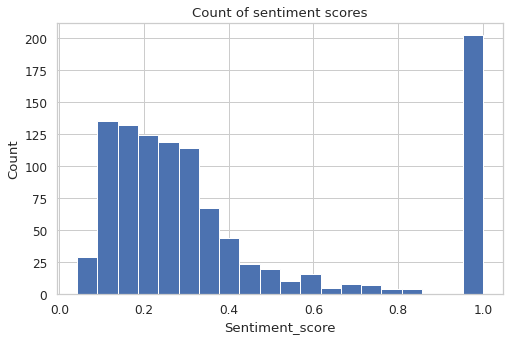

In [ ]:
# Graph to show the count of sentiment scores

import seaborn as sns

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    y_train, norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Sentiment_score', ylabel='Count', title = 'Count of sentiment scores');

Plot below shows the distribution of IMDB ratings in the dataset. Ratings are plotted after normalization and hence rangle is from 0 to 1 where 0 indicates poor rating and 1 indicates very high rating. we could find that most shows had an average rating and very less number of movies had very high rating.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



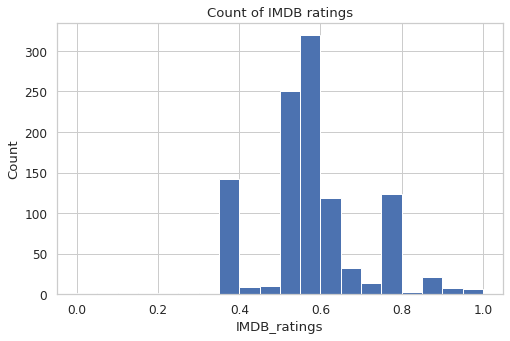

In [ ]:
# Graph to show the count of IMDB_ratings

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
     X_train[:, 2], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='IMDB_ratings', ylabel='Count', title="Count of IMDB ratings");

Plot shows distribution of four genres in the dataset. Most movies are of the genre Action and there are very small number of movies in comedy genre.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



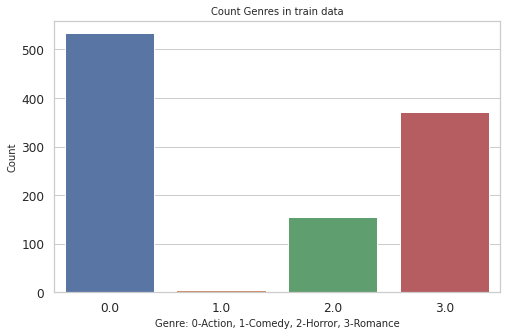

In [ ]:
# Graph to show the count of each Genre

sns.countplot(X_train[:, 3]);
plt.title("Count Genres in train data", fontsize = 10)
plt.xlabel("Genre: 0-Action, 1-Comedy, 2-Horror, 3-Romance", fontsize = 10)
plt.ylabel("Count", fontsize = 10)
plt.show()

Sentiment scores are discretized into 3 bins using Kbindiscretizer. This helps to reduce fluctuations in the data and to improve model performance. The bins are then visualized to check the count.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



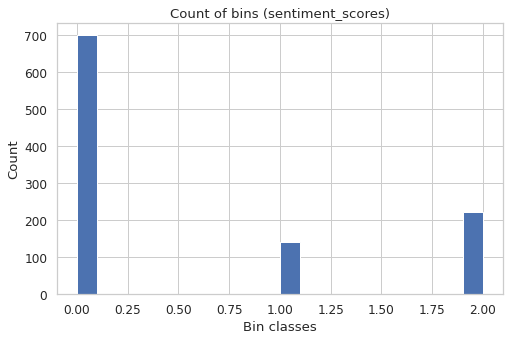

In [ ]:
#Discretizing the target variable into 3 bins

from sklearn.preprocessing import KBinsDiscretizer

kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
y_train = y_train.reshape(-1,1)
data_trans = kbins.fit_transform(y_train)

kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
y_test = y_test.reshape(-1,1)
data_trans_test = kbins.fit_transform(y_test)

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    data_trans, norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Bin classes', ylabel='Count', title="Count of bins (sentiment_scores)");

## **Single Layer Model**


First we build a single layer fully connected model with dropout of 50%. Show ids and user ids are embedded to create vectors. The show vector and user vector are multiplied to create user-item interaction matrix. Model is then compiled and evaluated.

In [ ]:
#Single Layer Model

def get_model_1(n_shows, n_users):
    dim_embedddings = 30
    bias = 3
    # inputs
    s_inputs = Input(shape=(1,), dtype='int32')
    show = Embedding(n_shows+1, dim_embedddings, name="show")(s_inputs)

    # context
    u_inputs = Input(shape=(1,), dtype='int32')
    user = Embedding(n_users+1, dim_embedddings, name="user")(u_inputs)
    o = multiply([show, user])
    o = Dropout(0.5)(o)
    o = Flatten()(o)
    o = Dense(1)(o)

    rec_model = Model(inputs=[s_inputs, u_inputs], outputs=o)
    #rec_model.summary()
    rec_model.compile(loss='mse', optimizer='adam', metrics=["mse", "accuracy"])

    return rec_model

In [ ]:
# Fitting of the data and predicting test data

from sklearn.metrics import mean_absolute_error
from keras.layers.merge import Dot, multiply, concatenate

model = get_model_1(n_shows, n_users)

history = model.fit([X_train[:, 0], X_train[:, 1]], data_trans, epochs=10,
                    validation_split=0.2, verbose=1)


predictions = model.predict([X_test[:, 0], X_test[:, 1]])

test_performance = mean_absolute_error(data_trans_test, predictions)

print(" Test Mse model 1 : %s " % test_performance)

Epoch 1/10
27/27 [==============================] - 1s 9ms/step - loss: 0.9615 - mse: 0.9615 - accuracy: 0.6528 - val_loss: 0.9982 - val_mse: 0.9982 - val_accuracy: 0.6338
Epoch 2/10
27/27 [==============================] - 0s 3ms/step - loss: 0.9297 - mse: 0.9297 - accuracy: 0.6566 - val_loss: 0.9702 - val_mse: 0.9702 - val_accuracy: 0.6338
Epoch 3/10
27/27 [==============================] - 0s 3ms/step - loss: 0.9298 - mse: 0.9298 - accuracy: 0.6476 - val_loss: 0.9442 - val_mse: 0.9442 - val_accuracy: 0.6338
Epoch 4/10
27/27 [==============================] - 0s 3ms/step - loss: 0.9261 - mse: 0.9261 - accuracy: 0.6511 - val_loss: 0.9204 - val_mse: 0.9204 - val_accuracy: 0.6338
Epoch 5/10
27/27 [==============================] - 0s 3ms/step - loss: 0.9595 - mse: 0.9595 - accuracy: 0.6274 - val_loss: 0.8979 - val_mse: 0.8979 - val_accuracy: 0.6338
Epoch 6/10
27/27 [==============================] - 0s 3ms/step - loss: 0.8667 - mse: 0.8667 - accuracy: 0.6606 - val_loss: 0.8776 - val_mse

**Evaluation of Single Layer Model**

Evaluation of model is done with the test data

*   List item
*   List item



Test loss (MSE) =
Test accuracy =

In [ ]:
# Final evaluation of the model

scores = model.evaluate(X_test_array, data_trans_test,  verbose=1) # testing data
scores

12/12 [==============================] - 0s 1ms/step - loss: 0.7923 - mse: 0.7923 - accuracy: 0.6507


[0.7922865152359009, 0.7922866344451904, 0.6507042050361633]

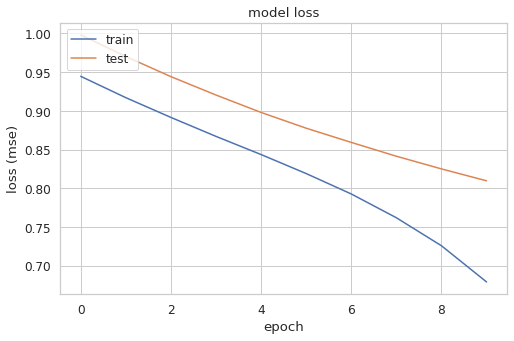

In [ ]:
# Plot to show model loss

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss (mse)")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Next, we build a single layer fully connected model with bias and compiled with loss function MSE and evaluated using metrics MSE and accuarcy.

In [ ]:
# Single layer model with bias 

def get_model_2(n_shows, n_users):
    dim_embedddings = 30
    bias = 1
    # inputs
    s_inputs = Input(shape=(1,), dtype='int32')
    s = Embedding(n_shows+1, dim_embedddings, name="show")(s_inputs)
    s_bis = Embedding(n_shows + 1, bias, name="showbias")(s_inputs)

    # context
    u_inputs = Input(shape=(1,), dtype='int32')
    u = Embedding(n_users+1, dim_embedddings, name="user")(u_inputs)
    u_bis = Embedding(n_users + 1, bias, name="userbias")(u_inputs)
    o = multiply([s, u])
    o = concatenate([o, u_bis, s_bis])
    o = Dropout(0.5)(o)
    o = Flatten()(o)
    o = Dense(1)(o)

    rec_model = Model(inputs=[s_inputs, u_inputs], outputs=o)
    #rec_model.summary()
    rec_model.compile(loss='mae', optimizer='adam', metrics=["mae", "accuracy"])

    return rec_model

In [ ]:
# Fitting of the data and making prediction

from sklearn.metrics import mean_absolute_error
from keras.layers.merge import Dot, multiply, concatenate

model = get_model_2(n_shows, n_users)

history = model.fit([X_train[:, 0], X_train[:, 1]], data_trans, epochs=10,
                    validation_split=0.2, verbose=1)

#model.save_weights("model_1.h5")

predictions = model.predict([X_test[:, 0], X_test[:, 1]])

test_performance = mean_absolute_error(data_trans_test, predictions)

print(" Test Mae model 2 : %s " % test_performance)

Epoch 1/10
27/27 [==============================] - 1s 9ms/step - loss: 0.5326 - mae: 0.5326 - accuracy: 0.6725 - val_loss: 0.5892 - val_mae: 0.5892 - val_accuracy: 0.6338
Epoch 2/10
27/27 [==============================] - 0s 3ms/step - loss: 0.5358 - mae: 0.5358 - accuracy: 0.6664 - val_loss: 0.5881 - val_mae: 0.5881 - val_accuracy: 0.6338
Epoch 3/10
27/27 [==============================] - 0s 3ms/step - loss: 0.5451 - mae: 0.5451 - accuracy: 0.6606 - val_loss: 0.5877 - val_mae: 0.5877 - val_accuracy: 0.6338
Epoch 4/10
27/27 [==============================] - 0s 3ms/step - loss: 0.5418 - mae: 0.5418 - accuracy: 0.6617 - val_loss: 0.5876 - val_mae: 0.5876 - val_accuracy: 0.6338
Epoch 5/10
27/27 [==============================] - 0s 14ms/step - loss: 0.5038 - mae: 0.5038 - accuracy: 0.6837 - val_loss: 0.5874 - val_mae: 0.5874 - val_accuracy: 0.6338
Epoch 6/10
27/27 [==============================] - 0s 4ms/step - loss: 0.5111 - mae: 0.5111 - accuracy: 0.6816 - val_loss: 0.5876 - val_ma

Evaluation of model is done with the test data


*   Test loss (MSE) 
*   Test accuracy 



In [ ]:
# Final evaluation of the single layer model

scores = model.evaluate(X_test_array, data_trans_test,  verbose=1) # testing data
scores

12/12 [==============================] - 0s 1ms/step - loss: 0.5732 - mae: 0.5732 - accuracy: 0.6507


[0.573236882686615, 0.573236882686615, 0.6507042050361633]

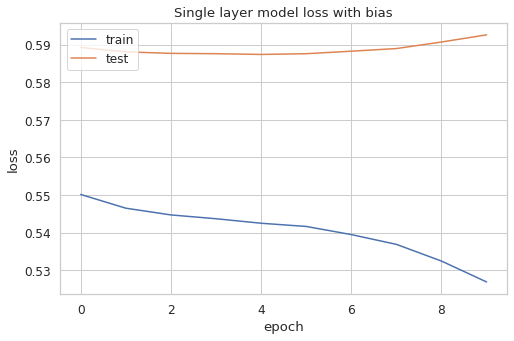

In [ ]:
# Plot to show model loss

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Single layer model loss with bias")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

From the above evaluation, we can see that there is no change in performance after adding bias and activation function hence we have improved the model by adding more layers to it and making it a multi layer model for getting more accurate predictions. 



## **Multi Layer Perceptron Model**

Following codes are for creating a deep learning MLP model using keras. Show ids and user ids are vectorized by embedding with an embedding size of 10. The embedded vectors are then concatenated and fed into the model

In [ ]:
#Model building using keras

embedding_size = 30

# Both inputs are 1-dimensional
show = Input(name = 'show_id', shape = [1])
user = Input(name = 'user', shape = [1])
genre = Input(name = 'genre_encoded', shape = [1])
    
    
# Embedding show (shape will be (None, 1, 10))
show_embedding = Embedding(name = 'show_embedding',
                               input_dim = n_shows + 1,
                               output_dim = embedding_size)(show)
flatten_s = keras.layers.Flatten()(show_embedding)
   
# Embedding user (shape will be (None, 1, 10))
user_embedding = Embedding(name = 'user_embedding',
                               input_dim = n_users + 1,
                               output_dim = embedding_size)(user)
flatten_u = keras.layers.Flatten()(user_embedding)

#genre_embedding = Embedding(name = 'genre_embedding',
                              # input_dim = n_genre + 1,
                              # output_dim = 2)(genre)
#flatten_g = keras.layers.Flatten()(genre_embedding)


#continuous_input = Input(name = 'rating', shape=(1, ), dtype='float32')
#continuous_input = keras.layers.Input(shape=(l,))


# Concatenate embedding inputs
concat = keras.layers.multiply([flatten_s, flatten_u])



Here we are defining the MLP model with 4 neurons each on 2 dense layers. Dropout of 40 % is added to reduce overfitting. Rectilinear activation function is used. Optimizer user id Adam optimizer and model is compiled with loss function of MSE and metrics analyzed are MSE and accuracy.

In [ ]:
# Define the model
from keras.optimizers import Adam

units=4
dense1 = Dense(units=units, activation='relu')(concat)
dense1 = Dropout(0.4)(concat) # adding droup out layer
dense2 = Dense(4, activation='relu')(dense1) # adding activation function to dense 
dense2 = Dropout(0.4)(dense1)
predictions = Dense(1)(dense1) # output layer

model_mlp = Model(inputs=[show, user], outputs=predictions)
opt = Adam(lr=0.001)


In [ ]:
# Compile the model
model_mlp.compile(loss='mean_squared_error', optimizer=opt, metrics = ['mse', 'accuracy'] )
model_mlp.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
show_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
show_embedding (Embedding)      (None, 1, 30)        2460        show_id[0][0]                    
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 30)        42450       user[0][0]                       
___________________________________________________________________________________________

In [ ]:
#Fit the model to the training value and train for 15 epoch for a batch size of 50

history_1 = model_mlp.fit(x=X_train_array, y= data_trans , batch_size=50, epochs= 15,
                    verbose=1, validation_data=(X_test_array, data_trans_test))

Epoch 1/15
22/22 [==============================] - 0s 6ms/step - loss: 0.6632 - mse: 0.6632 - accuracy: 0.6570 - val_loss: 0.8015 - val_mse: 0.8015 - val_accuracy: 0.6507
Epoch 2/15
22/22 [==============================] - 0s 4ms/step - loss: 0.6065 - mse: 0.6065 - accuracy: 0.6598 - val_loss: 0.7890 - val_mse: 0.7890 - val_accuracy: 0.6507
Epoch 3/15
22/22 [==============================] - 0s 4ms/step - loss: 0.5443 - mse: 0.5443 - accuracy: 0.7180 - val_loss: 0.7774 - val_mse: 0.7774 - val_accuracy: 0.6507
Epoch 4/15
22/22 [==============================] - 0s 4ms/step - loss: 0.4843 - mse: 0.4843 - accuracy: 0.7697 - val_loss: 0.7667 - val_mse: 0.7667 - val_accuracy: 0.6507
Epoch 5/15
22/22 [==============================] - 0s 4ms/step - loss: 0.4181 - mse: 0.4181 - accuracy: 0.7773 - val_loss: 0.7572 - val_mse: 0.7572 - val_accuracy: 0.6507
Epoch 6/15
22/22 [==============================] - 0s 4ms/step - loss: 0.3649 - mse: 0.3649 - accuracy: 0.7810 - val_loss: 0.7486 - val_mse

**Evaluation of Multi Layer Model**

Evaluation of model is done with the test data



1.   Test loss (MSE) 
2.   Test accuracy 





In [ ]:
# Model evaluation score for test data

scores_1 = model_mlp.evaluate(X_test_array, data_trans_test,  verbose=0) # testing data
scores_1



[0.7122902274131775, 0.7122902274131775, 0.6366197466850281]

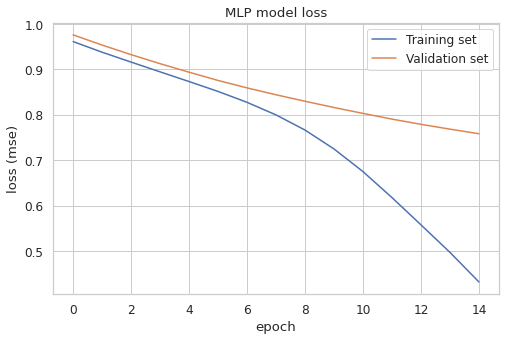

In [ ]:
# Plot to show model loss

plt.plot(history_1.history["loss"])
plt.plot(history_1.history["val_loss"])
plt.title("MLP model loss")
plt.ylabel("loss (mse)")
plt.xlabel("epoch")
plt.legend(["Training set", "Validation set"])
plt.show()

A MLP model with bias included for show and user ids. Model is then compiled and evaluated.




In [ ]:
#MLP Model with bias
from keras.layers import Add, Activation, Lambda

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
 

user = keras.Input(shape=(1,), name='n_users')
u = EmbeddingLayer(n_users, n_factors)(user)
ub = EmbeddingLayer(n_users, 1)(user)

movie = keras.Input(shape=(1,), name='n_movies')    
m = EmbeddingLayer(n_movies, n_factors)(movie)
mb = EmbeddingLayer(n_movies, 1)(movie)
    
x = keras.layers.Concatenate()([ub, mb])
   
x = Activation('relu')(x)
x = Lambda(lambda x: (x - min_senti_score) / (max_senti_score - min_senti_score))(x)
model = Model(inputs=[movie,user], outputs=x)
opt = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  
    
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
n_users (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
n_movies (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 1)         1414        n_users[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 1)         81          n_movies[0][0]                   
___________________________________________________________________________________________

In [ ]:
# Fitting the data to the model with bias

history_2 = model.fit(x=X_train_array, y=data_trans, batch_size=50, epochs=10,
                    verbose=1, validation_data=(X_test_array, data_trans_test))

Epoch 1/10
22/22 [==============================] - 1s 11ms/step - loss: 0.9361 - mse: 0.9361 - val_loss: 0.9605 - val_mse: 0.9605
Epoch 2/10
22/22 [==============================] - 0s 3ms/step - loss: 0.9781 - mse: 0.9781 - val_loss: 0.9550 - val_mse: 0.9550
Epoch 3/10
22/22 [==============================] - 0s 4ms/step - loss: 0.9096 - mse: 0.9096 - val_loss: 0.9499 - val_mse: 0.9499
Epoch 4/10
22/22 [==============================] - 0s 3ms/step - loss: 0.8964 - mse: 0.8964 - val_loss: 0.9457 - val_mse: 0.9457
Epoch 5/10
22/22 [==============================] - 0s 3ms/step - loss: 0.9689 - mse: 0.9689 - val_loss: 0.9416 - val_mse: 0.9416
Epoch 6/10
22/22 [==============================] - 0s 3ms/step - loss: 0.9210 - mse: 0.9210 - val_loss: 0.9380 - val_mse: 0.9380
Epoch 7/10
22/22 [==============================] - 0s 3ms/step - loss: 0.9558 - mse: 0.9558 - val_loss: 0.9346 - val_mse: 0.9346
Epoch 8/10
22/22 [==============================] - 0s 3ms/step - loss: 0.8536 - mse: 0.8

In [ ]:
# Final evaluation of the model

scores_2 = model.evaluate(X_test_array, data_trans_test,  verbose=1) # testing data
scores_2

12/12 [==============================] - 0s 1ms/step - loss: 0.9258 - mse: 0.9258


[0.9258191585540771, 0.9258154630661011]

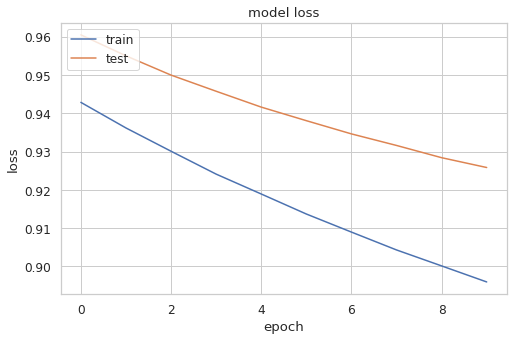

In [ ]:
# Model loss with bias 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.plot(history_2.history["loss"])
plt.plot(history_2.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

**Cross Validation**

In [ ]:
# Taking 20% of sample data from the model data for cross validation 
# Since the data is large , it is computationally expensive to do cross validation so we have 
# taken a portion of the data for cross validation

def frac(dataframe, fraction, other_info=None):
    """Returns fraction of data"""
    return dataframe.sample(frac=fraction)


df_data_1 = frac(df_data, 0.2) # Taking 20% of the model data 


In [301]:
## Cross validation 
# Cross Validation Regression MAE


# evaluate a logistic regression model using k-fold cross-validation
from sklearn.model_selection import RepeatedKFold, cross_val_score
from tensorflow.keras.models import * 
from tensorflow.keras.layers import * 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

x = df_data_1.iloc[:, [0, 1]]
y = df_data_1.Sentiment_score

# Building the model with activation function and fitting the data for each fold
def buildmodel():
    model= Sequential([
        Dense(4, activation="relu"),
        Dense(4, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return(model)

estimator= KerasRegressor(build_fn=buildmodel, epochs=100, batch_size=100, verbose=1)
kfold= RepeatedKFold(n_splits=5, n_repeats=10)
results= cross_val_score(estimator, x, y, cv=kfold, n_jobs=2, scoring='neg_mean_squared_error')  # 2 cpus
results

array([-3.23994863e-01, -1.38047516e-01, -1.46058798e+04, -1.26714929e+01,
       -2.56231738e+01, -4.58691814e+00, -1.98747776e+02, -6.91470609e+02,
       -2.78896086e+04, -1.88942181e+02, -1.56996057e+03, -1.02470652e+03,
       -9.17543177e-02, -1.26333410e-01, -1.76833891e+02, -2.53802331e+00,
       -2.47415936e+02, -4.21803588e+01, -6.95877567e-02, -1.35942830e-01,
       -1.54343760e+01, -7.05155616e+01, -2.40075634e-01, -2.24817871e+02,
       -6.39988097e-02, -4.13315627e+03, -3.55045045e-01, -4.76791558e+01,
       -1.29076482e+02, -1.10703901e+02, -1.45629600e+04, -1.31511641e+00,
       -2.06772766e-01, -2.43781758e+03, -4.21461404e+02, -4.57110476e+01,
       -1.03991089e-01, -1.25331259e-01, -6.86823276e+03, -1.07144280e-01,
       -1.10062118e-01, -4.40441239e+00, -9.23073287e-02, -9.82572727e-02,
       -1.54191856e-01, -1.09825812e+00, -2.24450535e-01, -6.27174344e+00,
       -3.28236115e+01, -3.69605991e-01])

In [ ]:
# Sentiment score for the test data using mlp model

s_scores = model_mlp.predict(X_test_array)
s_scores


array([[0.35345426],
       [0.416772  ],
       [0.35542116],
       [0.36380157],
       [0.43506745],
       [0.33816984],
       [0.33915836],
       [0.32127783],
       [0.35379648],
       [0.42762563],
       [0.34416857],
       [0.40171653],
       [0.36469668],
       [0.40765435],
       [0.41291362],
       [0.43319514],
       [0.28713048],
       [0.33465397],
       [0.39075962],
       [0.40247622],
       [0.42463043],
       [0.3665867 ],
       [0.44473866],
       [0.3965224 ],
       [0.26834357],
       [0.5023664 ],
       [0.37191302],
       [0.37505835],
       [0.30576095],
       [0.30522084],
       [0.3515712 ],
       [0.4212662 ],
       [0.4162337 ],
       [0.46423793],
       [0.41716453],
       [0.36214313],
       [0.3941342 ],
       [0.39841577],
       [0.5249151 ],
       [0.4533829 ],
       [0.35879785],
       [0.38338736],
       [0.42640987],
       [0.41259828],
       [0.3223138 ],
       [0.45971978],
       [0.2944419 ],
       [0.276

In [ ]:
# Filtering the model data for the recommendation

df_model_data1 = df_model_data[['show_id', 'title', 'IMDB_rating', 'genre_encoded', 'Sentiment_score']]
df_model_data = df_model_data.drop_duplicates().reset_index(drop=True)
df_model_data1 = df_model_data1.drop_duplicates().reset_index(drop=True)
df_model_data1.head()
df_model_data.head()

,show_id,title,user_id,Genre,Sentiment_score,IMDB_rating,genre_encoded,user,show
0,81049578,Tango,17904615,Romance,0.082,7.1,3,25,77
1,80169549,Incomplete,41304774,Romance,0.133,5.4,3,108,51
2,81021831,Sabrina,84945789,Horror,0.139,6.6,2,158,72
3,915927,Rocky,1146429722,Action,0.159,8.1,0,527,0
4,80082969,Delirium,2682146265,Horror,0.166,5.7,2,642,37


In [328]:
# Removing duplicates and sorting the sentiment score for each shows 
df_model_array = df_model_data[['show', 'IMDB_rating', 'genre_encoded']].drop_duplicates().reset_index(drop=True)

df_model_data = df_model_data.sort_values('Sentiment_score').drop_duplicates(subset=['show', 'genre_encoded', 'IMDB_rating', ], keep='last').reset_index(drop=True)


In [329]:
# Taking a sample twitter user from the model data for the recommendation

df_model_array = df_model_array.to_numpy() 
df_model_array[:, 0]

user = df_model_data.user.sample(1).iloc[0]
user

238

In [330]:
# Checking the user details from our analyzed data

df_model_data.loc[df_model_data['user'] == user]

,show_id,title,user_id,Genre,Sentiment_score,IMDB_rating,genre_encoded,user,show
40,80091879,Hush,202480252,Horror,0.651,6.6,2,238,38


In [331]:
# Locating the user to check tweets and it's corresponding sentiment score 

#df_data.loc[df_data['user'] == user]
usr = 202480252
data_clean.loc[data_clean['user_id'] == usr]


,user_id,title,text,Genre,show_id,created,pol_sub,text_clean,Sentiment_score
828,202480252,Hush,HUSH (2016) REVIEW! on Netflix \n-WOOOW this is an AMAZING thriller/realistic horror movie 😱\n-use headphones to real… https://t.co/gt3OdclWi1,Horror,80091879,2020-10-14 04:27:14,"(0.6000000000000001, 0.9)",hush review on netflix wooow this is an amazing thrillerrealistic horror movie use headphones to real,0.651


In [332]:
# User details before data encoding 

df_model_data.loc[df_model_data['user'] == user]

,show_id,title,user_id,Genre,Sentiment_score,IMDB_rating,genre_encoded,user,show
40,80091879,Hush,202480252,Horror,0.651,6.6,2,238,38


In [333]:
# Taking one user array with same length as show details for the sample user for prediction 

user = np.array([user for i in range(len(df_model_array[:, 0]))])
user

array([238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238,
       238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238,
       238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238,
       238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238,
       238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238,
       238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238,
       238, 238, 238])

In [345]:
# Prediction for a single user
pred = model_mlp.predict([df_model_array[:, 0], user])
#pred

In [362]:
## Get the index ids of top 5 sentiment scores
pred = pred.reshape(-1) #reshape to single dimension
pred_ids = (-pred).argsort()[1:11]
pred_ids



array([40, 63, 77, 72, 29, 45, 52,  2, 74, 12])

In [363]:
#Sentiment score predicted values

df_model_data1.iloc[pred_ids]

,show_id,title,IMDB_rating,genre_encoded,Sentiment_score
40,80091879,Hush,6.6,2,0.651
63,80158104,Taken,7.8,0,1.000
77,60028294,Popeye,5.3,0,1.000
72,70001082,Run,8.4,0,1.000
29,81087094,Lifechanger,5.4,2,0.321
45,81168340,Medium,6.9,2,1.000
52,80207371,Close,5.7,0,1.000
2,81021831,Sabrina,6.6,2,0.139
74,80022605,Remember,7.5,0,1.000
12,80141767,Tiger,6.4,0,0.214


For the user id 238, the user tweeted about the movie 'Hush' and the sentiment score for the tweet is 0.651	. The model predicted top 10 netflix shows for this user as above. Among these 10 suggestions, we can see that the model is recommending the user four horror genre movies i.e. same category of the movie he tweeted about. Based on the user's interaction and tweeted data, we can say that he will find one of these recommendations useful.

In [364]:
#since model_mlp performance is better than other models 
#checking prediction results for test data 

X_test_s = pd.DataFrame(X_test[:, 0]) # sentiment score 
X_test_u = pd.DataFrame(X_test[:, 1]) # user ids 

y_df = pd.DataFrame(y_test)

# sentiment score prediction
s_scores = pd.DataFrame(model_mlp.predict(X_test_array))

X_test_df = pd.concat([X_test_s, X_test_u, y_df ,s_scores], axis=1)
#s_scores

#test_df = pd.concat([X_test_df, s_scores], axis=1)
#test_df



In [365]:
X_test_df.columns = ['show_Id', 'user_Id', 'actual_ss', 'r_predictions']

In [ ]:
# Checking the actual sentiment score and the predicted score data using MLP model

X_test_df

,show_Id,user_Id,actual_ss,r_predictions
0,43.0,448.0,0.097,0.353454
1,2.0,629.0,0.158,0.416772
2,68.0,1141.0,0.268,0.355421
3,68.0,89.0,0.423,0.363802
4,2.0,431.0,0.179,0.435067
...,...,...,...,...
350,74.0,907.0,1.000,0.386031
351,33.0,130.0,0.121,0.485205
352,74.0,427.0,0.454,0.276338
353,2.0,65.0,1.000,0.408612


In [ ]:
##Evaluation using MSE, MAE and RMSE
from sklearn import metrics

print("MSE: ", metrics.mean_squared_error(X_test_df.actual_ss, X_test_df.r_predictions))
print("MAE: ", metrics.mean_absolute_error(X_test_df.actual_ss, X_test_df.r_predictions))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(X_test_df.actual_ss, X_test_df.r_predictions)))

MSE:  0.10506618873807119
MAE:  0.2590484098498251
RMSE:  0.3241391502704837


From the above evaluation details we can see that the mean squared error , mean absolute error and root mean squared errors are very less. So there is very less difference between the actual data and predicted data in test data set.